In [ ]:
!pip install forex_python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from forex_python.converter import CurrencyRates

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 5.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DTL/DRREDDY.NS.csv')

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-07-25,2619.800049,2666.000000,2607.250000,2654.100098,2571.718262,516388
1,2019-07-26,2640.050049,2714.000000,2621.699951,2704.949951,2620.989746,537619
2,2019-07-29,2709.899902,2726.800049,2621.300049,2653.949951,2571.572754,919633
3,2019-07-30,2648.000000,2693.500000,2549.100098,2560.000000,2480.538818,2197242
4,2019-07-31,2535.000000,2590.000000,2533.000000,2574.600098,2494.685791,834690
...,...,...,...,...,...,...,...
1230,2024-07-19,6660.000000,6718.399902,6626.299805,6636.000000,6636.000000,180068
1231,2024-07-22,6580.000000,6780.000000,6580.000000,6770.899902,6770.899902,412291
1232,2024-07-23,6770.000000,6884.000000,6717.000000,6865.000000,6865.000000,866091
1233,2024-07-24,6938.899902,6938.899902,6793.250000,6820.149902,6820.149902,603877


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1235 non-null   object 
 1   Open       1235 non-null   float64
 2   High       1235 non-null   float64
 3   Low        1235 non-null   float64
 4   Close      1235 non-null   float64
 5   Adj Close  1235 non-null   float64
 6   Volume     1235 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 67.7+ KB


In [ ]:
data.index = data['Date']
data.drop('Date', axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
price = data[['Close']]

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

<ipython-input-9-33ec0e5dddec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [ ]:
price

,Close
Date,
2019-07-25,-0.926105
2019-07-26,-0.902846
2019-07-29,-0.926174
2019-07-30,-0.969148
2019-07-31,-0.962470
...,...
2024-07-19,0.895253
2024-07-22,0.956958
2024-07-23,1.000000


In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [ ]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
# y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
# y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
input_dim = 1
hidden_dim = 64
num_layers = 2
output_dim = 1
num_epochs = 50

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.005)

In [ ]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
# lstm = []
gru = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))


Epoch  0 MSE:  0.11841672658920288
Epoch  1 MSE:  0.09308028966188431
Epoch  2 MSE:  0.07251214981079102
Epoch  3 MSE:  0.048950277268886566
Epoch  4 MSE:  0.0321502722799778
Epoch  5 MSE:  0.00971899088472128
Epoch  6 MSE:  0.012785844504833221
Epoch  7 MSE:  0.018354561179876328
Epoch  8 MSE:  0.015718232840299606
Epoch  9 MSE:  0.005809823051095009
Epoch  10 MSE:  0.0028390202205628157
Epoch  11 MSE:  0.006555017549544573
Epoch  12 MSE:  0.009182863868772984
Epoch  13 MSE:  0.009228966198861599
Epoch  14 MSE:  0.008357958868145943
Epoch  15 MSE:  0.006838380824774504
Epoch  16 MSE:  0.004437263123691082
Epoch  17 MSE:  0.002301860833540559
Epoch  18 MSE:  0.0023393642622977495
Epoch  19 MSE:  0.004046310670673847
Epoch  20 MSE:  0.004858934320509434
Epoch  21 MSE:  0.004600112326443195
Epoch  22 MSE:  0.003809552639722824
Epoch  23 MSE:  0.0025617158971726894
Epoch  24 MSE:  0.0017637450946494937
Epoch  25 MSE:  0.0020024236291646957
Epoch  26 MSE:  0.0026660803705453873
Epoch  27 M

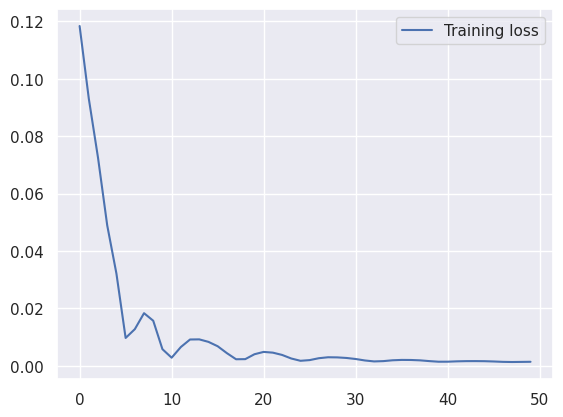

In [ ]:
plt.plot(hist, label='Training loss')
plt.legend()
plt.show()

In [ ]:
y_test_pred = model(x_test)
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train_gru = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test_gru = scaler.inverse_transform(y_test_gru.detach().numpy())



In [ ]:
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(y_train_gru[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test_gru[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 82.30 RMSE
Test Score: 100.25 RMSE


In [ ]:
import seaborn as sns

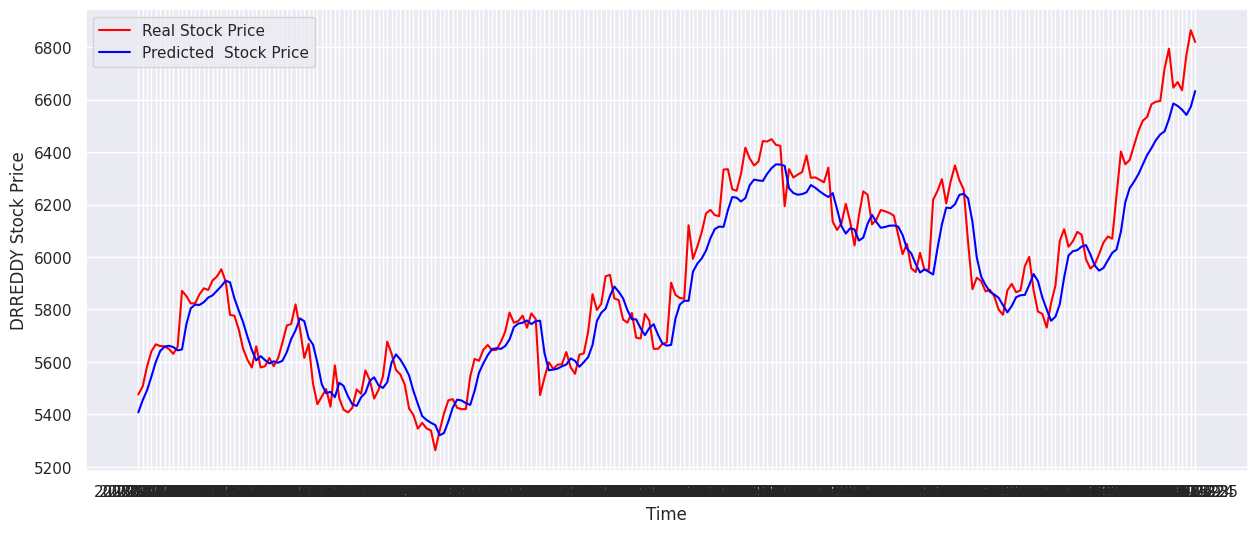

In [ ]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
sns.set_theme()
sns.set_style("darkgrid")
axes.plot(data[len(data)-len(y_test_gru):].index, y_test_gru, color = 'red', label = 'Real Stock Price')
axes.plot(data[len(data)-len(y_test_gru):].index, y_test_pred, color = 'blue', label = 'Predicted  Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.xlabel('Time')
plt.ylabel('DRREDDY Stock Price')
plt.legend()
plt.savefig('pred.png')
plt.show()

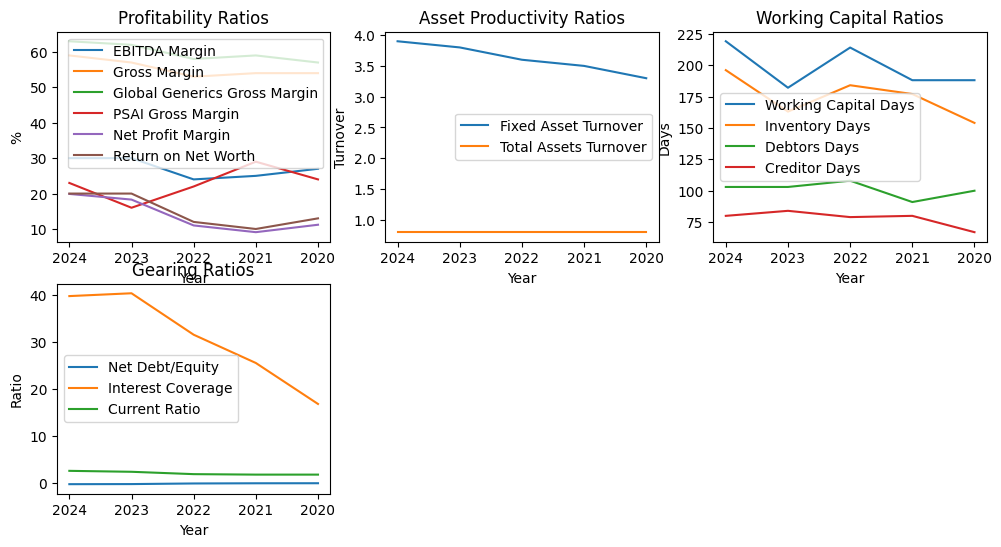

In [2]:
import matplotlib.pyplot as plt

# Define the data
years = ['2024', '2023', '2022', '2021', '2020']

# Profitability Ratios
ebitda_margin = [30, 30, 24, 25, 27]
gross_margin = [59, 57, 53, 54, 54]
global_generics_gross_margin = [63, 62, 58, 59, 57]
psai_gross_margin = [23, 16, 22, 29, 24]
net_profit_margin = [19.9, 18.3, 11.0, 9.1, 11.2]
return_on_net_worth = [20, 20, 12, 10, 13]

# Asset Productivity Ratios
fixed_asset_turnover = [3.9, 3.8, 3.6, 3.5, 3.3]
total_assets_turnover = [0.8, 0.8, 0.8, 0.8, 0.8]

# Working Capital Ratios
working_capital_days = [219, 182, 214, 188, 188]
inventory_days = [196, 163, 184, 177, 154]
debtors_days = [103, 103, 108, 91, 100]
creditor_days = [80, 84, 79, 80, 67]

# Gearing Ratios
net_debt_equity = [-0.23, -0.21, -0.08, -0.04, -0.03]
interest_coverage = [39.7, 40.3, 31.5, 25.5, 16.8]
current_ratio = [2.6, 2.4, 1.9, 1.8, 1.8]

# Valuation Ratios
earnings_per_share = [334.0, 270.9, 141.7, 103.6, 117.4]
book_value_per_share = [1683, 1388, 1145, 1041, 933]
dividend_payout = [12, 15, 21, 24, 21]
trailing_price_earnings_ratio = [18.4, 17.1, 30.3, 43.6, 26.6]

# Create the graphs
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.plot(years, ebitda_margin, label='EBITDA Margin')
plt.plot(years, gross_margin, label='Gross Margin')
plt.plot(years, global_generics_gross_margin, label='Global Generics Gross Margin')
plt.plot(years, psai_gross_margin, label='PSAI Gross Margin')
plt.plot(years, net_profit_margin, label='Net Profit Margin')
plt.plot(years, return_on_net_worth, label='Return on Net Worth')
plt.title('Profitability Ratios')
plt.xlabel('Year')
plt.ylabel('%')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(years, fixed_asset_turnover, label='Fixed Asset Turnover')
plt.plot(years, total_assets_turnover, label='Total Assets Turnover')
plt.title('Asset Productivity Ratios')
plt.xlabel('Year')
plt.ylabel('Turnover')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(years, working_capital_days, label='Working Capital Days')
plt.plot(years, inventory_days, label='Inventory Days')
plt.plot(years, debtors_days, label='Debtors Days')
plt.plot(years, creditor_days, label='Creditor Days')
plt.title('Working Capital Ratios')
plt.xlabel('Year')
plt.ylabel('Days')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(years, net_debt_equity, label='Net Debt/Equity')
plt.plot(years, interest_coverage, label='Interest Coverage')
plt.plot(years, current_ratio, label='Current Ratio')
plt.title('Gearing Ratios')
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.legend()
